<a href="https://colab.research.google.com/github/fwangliberty/AIoTDesign-Frontend/blob/master/Mobilenetv2_garbage_implementation2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
Directly using mobilenetv3 to train a neural network, it can give a very good accuracy (about 99%). On the other hand, using tranfer learning, a pre-trained mobilenetv3 model (imagenet) only provides about 86$. 

# 1. Connect to Google Drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Mounted at /content/drive

In [48]:
!ls "/content/drive/My Drive/Garbage classification/"


cardboard  glass  metal  paper	plastic  trash


In [70]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, BatchNormalization, Activation, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D, Add, Reshape, DepthwiseConv2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
import glob, os, random
import numpy as np
import matplotlib.pyplot as plt

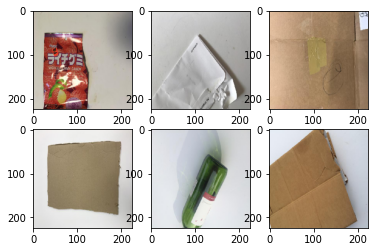

In [7]:
from keras.preprocessing import image
base_path = '/content/drive/My Drive/Garbage classification'
img_list = glob.glob(os.path.join(base_path, '*/*.jpg'))

for i, img_path in enumerate(random.sample(img_list, 6)):
    img = image.load_img(img_path, target_size=(224, 224))
    img = image.img_to_array(img, dtype=np.uint8)
    plt.subplot(2, 3, i+1)
    plt.imshow(img.squeeze())

In [103]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    shear_range=0.1,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.1
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1
)

train_generator = train_datagen.flow_from_directory(
    base_path,
    target_size=(224, 224),
    batch_size= 16,
    class_mode='categorical',
    subset='training',
    seed=0
)

validation_generator = test_datagen.flow_from_directory(
    base_path,
    target_size=(224, 224),
    batch_size= 16,
    class_mode='categorical',
    subset='validation',
    seed=0
)


Found 2276 images belonging to 6 classes.
Found 251 images belonging to 6 classes.


In [9]:
for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape

((16, 224, 224, 3), (16, 6))

In [10]:
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels)



{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}


In [11]:
!ls

drive  labels.txt  sample_data


In [12]:
path = 'labels.txt'
label = np.array(open(path).read().splitlines())

# 2. Implemneting MobileNetv3 Model
Source: https://github.com/keras-team/keras-applications/blob/master/keras_applications/mobilenet_v3.py


In [66]:
from keras import backend as K

In [50]:
backend = None
layers = None
models = None
keras_utils = None

In [63]:
_KERAS_BACKEND = None
_KERAS_LAYERS = None
_KERAS_MODELS = None
_KERAS_UTILS = None

In [51]:
CLASS_INDEX = None
CLASS_INDEX_PATH = ('https://storage.googleapis.com/download.tensorflow.org/'
                    'data/imagenet_class_index.json')

In [75]:
def correct_pad(backend, inputs, kernel_size):
    """Returns a tuple for zero-padding for 2D convolution with downsampling.
    # Arguments
        input_size: An integer or tuple/list of 2 integers.
        kernel_size: An integer or tuple/list of 2 integers.
    # Returns
        A tuple.
    """
    img_dim = 2 if K.image_data_format() == 'channels_first' else 1
    input_size = K.int_shape(inputs)[img_dim:(img_dim + 2)]

    if isinstance(kernel_size, int):
        kernel_size = (kernel_size, kernel_size)

    if input_size[0] is None:
        adjust = (1, 1)
    else:
        adjust = (1 - input_size[0] % 2, 1 - input_size[1] % 2)

    correct = (kernel_size[0] // 2, kernel_size[1] // 2)

    return ((correct[0] - adjust[0], correct[0]),
            (correct[1] - adjust[1], correct[1]))

In [76]:
def get_submodules_from_kwargs(kwargs):
    backend = kwargs.get('backend', _KERAS_BACKEND)
    layers = kwargs.get('layers', _KERAS_LAYERS)
    models = kwargs.get('models', _KERAS_MODELS)
    utils = kwargs.get('utils', _KERAS_UTILS)
    for key in kwargs.keys():
        if key not in ['backend', 'layers', 'models', 'utils']:
            raise TypeError('Invalid keyword argument: %s', key)
    return backend, layers, models, utils

In [77]:
def _obtain_input_shape(input_shape,
                        default_size,
                        min_size,
                        data_format,
                        require_flatten,
                        weights=None):
    """Internal utility to compute/validate a model's input shape.
    # Arguments
        input_shape: Either None (will return the default network input shape),
            or a user-provided shape to be validated.
        default_size: Default input width/height for the model.
        min_size: Minimum input width/height accepted by the model.
        data_format: Image data format to use.
        require_flatten: Whether the model is expected to
            be linked to a classifier via a Flatten layer.
        weights: One of `None` (random initialization)
            or 'imagenet' (pre-training on ImageNet).
            If weights='imagenet' input channels must be equal to 3.
    # Returns
        An integer shape tuple (may include None entries).
    # Raises
        ValueError: In case of invalid argument values.
    """
    if weights != 'imagenet' and input_shape and len(input_shape) == 3:
        if data_format == 'channels_first':
            if input_shape[0] not in {1, 3}:
                warnings.warn(
                    'This model usually expects 1 or 3 input channels. '
                    'However, it was passed an input_shape with ' +
                    str(input_shape[0]) + ' input channels.')
            default_shape = (input_shape[0], default_size, default_size)
        else:
            if input_shape[-1] not in {1, 3}:
                warnings.warn(
                    'This model usually expects 1 or 3 input channels. '
                    'However, it was passed an input_shape with ' +
                    str(input_shape[-1]) + ' input channels.')
            default_shape = (default_size, default_size, input_shape[-1])
    else:
        if data_format == 'channels_first':
            default_shape = (3, default_size, default_size)
        else:
            default_shape = (default_size, default_size, 3)
    if weights == 'imagenet' and require_flatten:
        if input_shape is not None:
            if input_shape != default_shape:
                raise ValueError('When setting `include_top=True` '
                                 'and loading `imagenet` weights, '
                                 '`input_shape` should be ' +
                                 str(default_shape) + '.')
        return default_shape
    if input_shape:
        if data_format == 'channels_first':
            if input_shape is not None:
                if len(input_shape) != 3:
                    raise ValueError(
                        '`input_shape` must be a tuple of three integers.')
                if input_shape[0] != 3 and weights == 'imagenet':
                    raise ValueError('The input must have 3 channels; got '
                                     '`input_shape=' + str(input_shape) + '`')
                if ((input_shape[1] is not None and input_shape[1] < min_size) or
                   (input_shape[2] is not None and input_shape[2] < min_size)):
                    raise ValueError('Input size must be at least ' +
                                     str(min_size) + 'x' + str(min_size) +
                                     '; got `input_shape=' +
                                     str(input_shape) + '`')
        else:
            if input_shape is not None:
                if len(input_shape) != 3:
                    raise ValueError(
                        '`input_shape` must be a tuple of three integers.')
                if input_shape[-1] != 3 and weights == 'imagenet':
                    raise ValueError('The input must have 3 channels; got '
                                     '`input_shape=' + str(input_shape) + '`')
                if ((input_shape[0] is not None and input_shape[0] < min_size) or
                   (input_shape[1] is not None and input_shape[1] < min_size)):
                    raise ValueError('Input size must be at least ' +
                                     str(min_size) + 'x' + str(min_size) +
                                     '; got `input_shape=' +
                                     str(input_shape) + '`')
    else:
        if require_flatten:
            input_shape = default_shape
        else:
            if data_format == 'channels_first':
                input_shape = (3, None, None)
            else:
                input_shape = (None, None, 3)
    if require_flatten:
        if None in input_shape:
            raise ValueError('If `include_top` is True, '
                             'you should specify a static `input_shape`. '
                             'Got `input_shape=' + str(input_shape) + '`')
    return input_shape

In [78]:
def decode_predictions(preds, top=5, **kwargs):
    """Decodes the prediction of an ImageNet model.
    # Arguments
        preds: Numpy tensor encoding a batch of predictions.
        top: Integer, how many top-guesses to return.
    # Returns
        A list of lists of top class prediction tuples
        `(class_name, class_description, score)`.
        One list of tuples per sample in batch input.
    # Raises
        ValueError: In case of invalid shape of the `pred` array
            (must be 2D).
    """
    global CLASS_INDEX

    backend, _, _, keras_utils = get_submodules_from_kwargs(kwargs)

    if len(preds.shape) != 2 or preds.shape[1] != 1000:
        raise ValueError('`decode_predictions` expects '
                         'a batch of predictions '
                         '(i.e. a 2D array of shape (samples, 1000)). '
                         'Found array with shape: ' + str(preds.shape))
    if CLASS_INDEX is None:
        fpath = keras_utils.get_file(
            'imagenet_class_index.json',
            CLASS_INDEX_PATH,
            cache_subdir='models',
            file_hash='c2c37ea517e94d9795004a39431a14cb')
        with open(fpath) as f:
            CLASS_INDEX = json.load(f)
    results = []
    for pred in preds:
        top_indices = pred.argsort()[-top:][::-1]
        result = [tuple(CLASS_INDEX[str(i)]) + (pred[i],) for i in top_indices]
        result.sort(key=lambda x: x[2], reverse=True)
        results.append(result)
    return results


In [84]:
def relu(x):
    return tf.keras.layers.ReLU()(x)

In [83]:
def hard_sigmoid(x):
    return tf.keras.layers.ReLU(6.)(x + 3.) * (1. / 6.)

In [82]:
def hard_swish(x):
    return tf.keras.layers.Multiply()([tf.keras.layers.Activation(hard_sigmoid)(x), x])

In [58]:
def _depth(v, divisor=8, min_value=None):
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v

In [88]:
def _se_block(inputs, filters, se_ratio, prefix):
    x = tf.keras.layers.GlobalAveragePooling2D(name=prefix + 'squeeze_excite/AvgPool')(inputs)
    if K.image_data_format() == 'channels_first':
        x = tf.keras.layers.Reshape((filters, 1, 1))(x)
    else:
        x = tf.keras.layers.Reshape((1, 1, filters))(x)
    x = tf.keras.layers.Conv2D(_depth(filters * se_ratio),
                      kernel_size=1,
                      padding='same',
                      name=prefix + 'squeeze_excite/Conv')(x)
    x = tf.keras.layers.ReLU(name=prefix + 'squeeze_excite/Relu')(x)
    x = tf.keras.layers.Conv2D(filters,
                      kernel_size=1,
                      padding='same',
                      name=prefix + 'squeeze_excite/Conv_1')(x)
    x = tf.keras.layers.Activation(hard_sigmoid)(x)
    if K.backend() == 'theano':
        # For the Theano backend, we have to explicitly make
        # the excitation weights broadcastable.
        x = tf.keras.layers.Lambda(
            lambda br: backend.pattern_broadcast(br, [True, True, True, False]),
            output_shape=lambda input_shape: input_shape,
            name=prefix + 'squeeze_excite/broadcast')(x)
    x = tf.keras.layers.Multiply(name=prefix + 'squeeze_excite/Mul')([inputs, x])
    return x

In [86]:
def _inverted_res_block(x, expansion, filters, kernel_size, stride,
                        se_ratio, activation, block_id):
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1
    shortcut = x
    prefix = 'expanded_conv/'
    infilters = K.int_shape(x)[channel_axis]
    if block_id:
        # Expand
        prefix = 'expanded_conv_{}/'.format(block_id)
        x = tf.keras.layers.Conv2D(_depth(infilters * expansion),
                          kernel_size=1,
                          padding='same',
                          use_bias=False,
                          name=prefix + 'expand')(x)
        x = tf.keras.layers.BatchNormalization(axis=channel_axis,
                                      epsilon=1e-3,
                                      momentum=0.999,
                                      name=prefix + 'expand/BatchNorm')(x)
        x = tf.keras.layers.Activation(activation)(x)

    if stride == 2:
        x = tf.keras.layers.ZeroPadding2D(padding=correct_pad(backend, x, kernel_size),
                                 name=prefix + 'depthwise/pad')(x)
    x = tf.keras.layers.DepthwiseConv2D(kernel_size,
                               strides=stride,
                               padding='same' if stride == 1 else 'valid',
                               use_bias=False,
                               name=prefix + 'depthwise')(x)
    x = tf.keras.layers.BatchNormalization(axis=channel_axis,
                                  epsilon=1e-3,
                                  momentum=0.999,
                                  name=prefix + 'depthwise/BatchNorm')(x)
    x = tf.keras.layers.Activation(activation)(x)

    if se_ratio:
        x = _se_block(x, _depth(infilters * expansion), se_ratio, prefix)

    x = tf.keras.layers.Conv2D(filters,
                      kernel_size=1,
                      padding='same',
                      use_bias=False,
                      name=prefix + 'project')(x)
    x = tf.keras.layers.BatchNormalization(axis=channel_axis,
                                  epsilon=1e-3,
                                  momentum=0.999,
                                  name=prefix + 'project/BatchNorm')(x)

    if stride == 1 and infilters == filters:
        x = tf.keras.layers.Add(name=prefix + 'Add')([shortcut, x])
    return x


In [96]:
def MobileNetV3(stack_fn,
                last_point_ch,
                input_shape=None,
                alpha=1.0,
                model_type='large',
                minimalistic=False,
                include_top=True,
                weights='imagenet',
                input_tensor=None,
                classes=1000,
                pooling=None,
                dropout_rate=0.2,
                **kwargs):
    """Instantiates the MobileNetV3 architecture.
    # Arguments
        stack_fn: a function that returns output tensor for the
            stacked residual blocks.
        last_point_ch: number channels at the last layer (before top)
        input_shape: optional shape tuple, to be specified if you would
            like to use a model with an input img resolution that is not
            (224, 224, 3).
            It should have exactly 3 inputs channels (224, 224, 3).
            You can also omit this option if you would like
            to infer input_shape from an input_tensor.
            If you choose to include both input_tensor and input_shape then
            input_shape will be used if they match, if the shapes
            do not match then we will throw an error.
            E.g. `(160, 160, 3)` would be one valid value.
        alpha: controls the width of the network. This is known as the
            depth multiplier in the MobileNetV3 paper, but the name is kept for
            consistency with MobileNetV1 in Keras.
            - If `alpha` < 1.0, proportionally decreases the number
                of filters in each layer.
            - If `alpha` > 1.0, proportionally increases the number
                of filters in each layer.
            - If `alpha` = 1, default number of filters from the paper
                are used at each layer.
        model_type: MobileNetV3 is defined as two models: large and small. These
        models are targeted at high and low resource use cases respectively.
        minimalistic: In addition to large and small models this module also contains
            so-called minimalistic models, these models have the same per-layer
            dimensions characteristic as MobilenetV3 however, they don't utilize any
            of the advanced blocks (squeeze-and-excite units, hard-swish, and 5x5
            convolutions). While these models are less efficient on CPU, they are
            much more performant on GPU/DSP.
        include_top: whether to include the fully-connected
            layer at the top of the network.
        weights: one of `None` (random initialization),
              'imagenet' (pre-training on ImageNet),
              or the path to the weights file to be loaded.
        input_tensor: optional Keras tensor (i.e. output of
            `layers.Input()`)
            to use as image input for the model.
        classes: optional number of classes to classify images
            into, only to be specified if `include_top` is True, and
            if no `weights` argument is specified.
        pooling: optional pooling mode for feature extraction
            when `include_top` is `False`.
            - `None` means that the output of the model will be
                the 4D tensor output of the
                last convolutional layer.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional layer, and thus
                the output of the model will be a 2D tensor.
            - `max` means that global max pooling will
                be applied.
        dropout_rate: fraction of the input units to drop on the last layer
    # Returns
        A Keras model instance.
    # Raises
        ValueError: in case of invalid model type, argument for `weights`,
            or invalid input shape when weights='imagenet'
    """
    global backend, layers, models, keras_utils
    backend, layers, models, keras_utils = get_submodules_from_kwargs(kwargs)

    if not (weights in {'imagenet', None} or os.path.exists(weights)):
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization), `imagenet` '
                         '(pre-training on ImageNet), '
                         'or the path to the weights file to be loaded.')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as `"imagenet"` with `include_top` '
                         'as true, `classes` should be 1000')

    # Determine proper input shape and default size.
    # If both input_shape and input_tensor are used, they should match
    if input_shape is not None and input_tensor is not None:
        try:
            is_input_t_tensor = backend.is_keras_tensor(input_tensor)
        except ValueError:
            try:
                is_input_t_tensor = backend.is_keras_tensor(
                    keras_utils.get_source_inputs(input_tensor))
            except ValueError:
                raise ValueError('input_tensor: ', input_tensor,
                                 'is not type input_tensor')
        if is_input_t_tensor:
            if K.image_data_format == 'channels_first':
                if K.int_shape(input_tensor)[1] != input_shape[1]:
                    raise ValueError('input_shape: ', input_shape,
                                     'and input_tensor: ', input_tensor,
                                     'do not meet the same shape requirements')
            else:
                if K.int_shape(input_tensor)[2] != input_shape[1]:
                    raise ValueError('input_shape: ', input_shape,
                                     'and input_tensor: ', input_tensor,
                                     'do not meet the same shape requirements')
        else:
            raise ValueError('input_tensor specified: ', input_tensor,
                             'is not a keras tensor')

    # If input_shape is None, infer shape from input_tensor
    if input_shape is None and input_tensor is not None:

        try:
            backend.is_keras_tensor(input_tensor)
        except ValueError:
            raise ValueError('input_tensor: ', input_tensor,
                             'is type: ', type(input_tensor),
                             'which is not a valid type')

        if backend.is_keras_tensor(input_tensor):
            if K.image_data_format() == 'channels_first':
                rows = backend.int_shape(input_tensor)[2]
                cols = backend.int_shape(input_tensor)[3]
                input_shape = (3, cols, rows)
            else:
                rows = backend.int_shape(input_tensor)[1]
                cols = backend.int_shape(input_tensor)[2]
                input_shape = (cols, rows, 3)
    # If input_shape is None and input_tensor is None using standart shape
    if input_shape is None and input_tensor is None:
        input_shape = (None, None, 3)

    if K.image_data_format() == 'channels_last':
        row_axis, col_axis = (0, 1)
    else:
        row_axis, col_axis = (1, 2)
    rows = input_shape[row_axis]
    cols = input_shape[col_axis]
    if rows and cols and (rows < 32 or cols < 32):
        raise ValueError('Input size must be at least 32x32; got `input_shape=' +
                         str(input_shape) + '`')
    if weights == 'imagenet':
        if minimalistic is False and alpha not in [0.75, 1.0] \
                or minimalistic is True and alpha != 1.0:
            raise ValueError('If imagenet weights are being loaded, '
                             'alpha can be one of `0.75`, `1.0` for non minimalistic'
                             ' or `1.0` for minimalistic only.')

        if rows != cols or rows != 224:
            warnings.warn('`input_shape` is undefined or non-square, '
                          'or `rows` is not 224.'
                          ' Weights for input shape (224, 224) will be'
                          ' loaded as the default.')

    if input_tensor is None:
        img_input = tf.keras.layers.Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = tf.keras.layers.Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1

    if minimalistic:
        kernel = 3
        activation = relu
        se_ratio = None
    else:
        kernel = 5
        activation = hard_swish
        se_ratio = 0.25

    x = tf.keras.layers.ZeroPadding2D(padding=correct_pad(backend, img_input, 3),
                             name='Conv_pad')(img_input)
    x = tf.keras.layers.Conv2D(16,
                      kernel_size=3,
                      strides=(2, 2),
                      padding='valid',
                      use_bias=False,
                      name='Conv')(x)
    x = tf.keras.layers.BatchNormalization(axis=channel_axis,
                                  epsilon=1e-3,
                                  momentum=0.999,
                                  name='Conv/BatchNorm')(x)
    x = tf.keras.layers.Activation(activation)(x)

    x = stack_fn(x, kernel, activation, se_ratio)

    last_conv_ch = _depth(K.int_shape(x)[channel_axis] * 6)

    # if the width multiplier is greater than 1 we
    # increase the number of output channels
    if alpha > 1.0:
        last_point_ch = _depth(last_point_ch * alpha)

    x = tf.keras.layers.Conv2D(last_conv_ch,
                      kernel_size=1,
                      padding='same',
                      use_bias=False,
                      name='Conv_1')(x)
    x = tf.keras.layers.BatchNormalization(axis=channel_axis,
                                  epsilon=1e-3,
                                  momentum=0.999,
                                  name='Conv_1/BatchNorm')(x)
    x = tf.keras.layers.Activation(activation)(x)

    if include_top:
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        if channel_axis == 1:
            x = tf.keras.layers.Reshape((last_conv_ch, 1, 1))(x)
        else:
            x = tf.keras.layers.Reshape((1, 1, last_conv_ch))(x)
        x = tf.keras.layers.Conv2D(last_point_ch,
                          kernel_size=1,
                          padding='same',
                          name='Conv_2')(x)
        x = tf.keras.layers.Activation(activation)(x)
        if dropout_rate > 0:
            x = tf.keras.layers.Dropout(dropout_rate)(x)
        x = tf.keras.layers.Conv2D(classes,
                          kernel_size=1,
                          padding='same',
                          name='Logits')(x)
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Softmax(name='Predictions/Softmax')(x)
    else:
        if pooling == 'avg':
            x = tf.keras.layers.GlobalAveragePooling2D(name='avg_pool')(x)
        elif pooling == 'max':
            x = tf.keras.layers.GlobalMaxPooling2D(name='max_pool')(x)
    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = keras_utils.get_source_inputs(input_tensor)
    else:
        inputs = img_input

    # Create model.
    model =  Model(inputs, x, name='MobilenetV3' + model_type)

    return model

In [73]:
def MobileNetV3Small(input_shape=None,
                     alpha=1.0,
                     minimalistic=False,
                     include_top=True,
                     weights='imagenet',
                     input_tensor=None,
                     classes=1000,
                     pooling=None,
                     dropout_rate=0.2,
                     **kwargs):
    def stack_fn(x, kernel, activation, se_ratio):
        def depth(d):
            return _depth(d * alpha)
        x = _inverted_res_block(x, 1, depth(16), 3, 2, se_ratio, relu, 0)
        x = _inverted_res_block(x, 72. / 16, depth(24), 3, 2, None, relu, 1)
        x = _inverted_res_block(x, 88. / 24, depth(24), 3, 1, None, relu, 2)
        x = _inverted_res_block(x, 4, depth(40), kernel, 2, se_ratio, activation, 3)
        x = _inverted_res_block(x, 6, depth(40), kernel, 1, se_ratio, activation, 4)
        x = _inverted_res_block(x, 6, depth(40), kernel, 1, se_ratio, activation, 5)
        x = _inverted_res_block(x, 3, depth(48), kernel, 1, se_ratio, activation, 6)
        x = _inverted_res_block(x, 3, depth(48), kernel, 1, se_ratio, activation, 7)
        x = _inverted_res_block(x, 6, depth(96), kernel, 2, se_ratio, activation, 8)
        x = _inverted_res_block(x, 6, depth(96), kernel, 1, se_ratio, activation, 9)
        x = _inverted_res_block(x, 6, depth(96), kernel, 1, se_ratio, activation, 10)
        return x
    return MobileNetV3(stack_fn,
                       1024,
                       input_shape,
                       alpha,
                       'small',
                       minimalistic,
                       include_top,
                       weights,
                       input_tensor,
                       classes,
                       pooling,
                       dropout_rate,
                       **kwargs)

In [99]:
IMG_SHAPE = (224,224,3)
 
base_model = MobileNetV3Small(input_shape=IMG_SHAPE,
                              include_top= True,  dropout_rate = 0.9, 
                              classes= 6,
                              weights= None)
base_model.summary()

Model: "MobilenetV3small"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv_pad (ZeroPadding2D)        (None, 225, 225, 3)  0           input_11[0][0]                   
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 112, 112, 16) 432         Conv_pad[0][0]                   
__________________________________________________________________________________________________
Conv/BatchNorm (BatchNormalizat (None, 112, 112, 16) 64          Conv[0][0]                       
___________________________________________________________________________________

In [100]:
base_model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4),   
              loss='categorical_crossentropy', 
              metrics=['acc'])

In [101]:
batch_size = 16
epochs = 50
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size

history = base_model.fit(train_generator, 
                              steps_per_epoch = steps_per_epoch,
                              epochs=epochs, 
                              workers=4,
                              validation_data=validation_generator, 
                              validation_steps=validation_steps)

Epoch 1/50
142/142 [==============================] - 176s 1s/step - loss: 1.7247 - acc: 0.2978 - val_loss: 1.7847 - val_acc: 0.1875
Epoch 2/50
142/142 [==============================] - 29s 202ms/step - loss: 1.5260 - acc: 0.3845 - val_loss: 1.7815 - val_acc: 0.1958
Epoch 3/50
142/142 [==============================] - 28s 200ms/step - loss: 1.4529 - acc: 0.4128 - val_loss: 1.7797 - val_acc: 0.2042
Epoch 4/50
142/142 [==============================] - 28s 200ms/step - loss: 1.3352 - acc: 0.4823 - val_loss: 1.7775 - val_acc: 0.2000
Epoch 5/50
142/142 [==============================] - 28s 200ms/step - loss: 1.2858 - acc: 0.5164 - val_loss: 1.7790 - val_acc: 0.2000
Epoch 6/50
142/142 [==============================] - 28s 199ms/step - loss: 1.2411 - acc: 0.5420 - val_loss: 1.7794 - val_acc: 0.2000
Epoch 7/50
142/142 [==============================] - 28s 200ms/step - loss: 1.1941 - acc: 0.5588 - val_loss: 1.7771 - val_acc: 0.2000
Epoch 8/50
142/142 [==============================] - 28s

KeyboardInterrupt: ignored

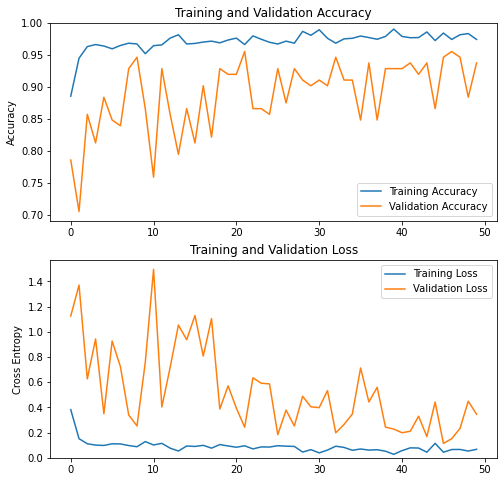

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

(1, 6)
cardboard


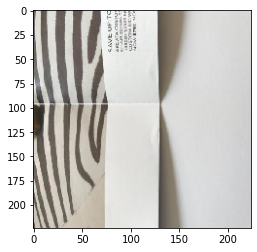

In [ ]:
img_path = '/content/drive/My Drive/Garbage classification/paper/paper8.jpg'

img=np.array(img)/255.0
img = image.load_img(img_path, target_size=(224, 224))
img = image.img_to_array(img, dtype=np.uint8)
plt.imshow(img.squeeze())
p=model.predict(img[np.newaxis, ...])
print(p.shape)
predicted_class = label[np.argmax(p[0][0], axis=-1)]
print(predicted_class)

## Fine Tuning
If the base model is learnt by transfer learning, the following code is running. Otherwise, skip it.

In [ ]:
# if using transfer learning
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine tune from this layer onwards
fine_tune_at = 91

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  155


Fine Tuning MobileNetV2

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(1e-5), 
              metrics=['acc'])

In [102]:
history_fine = model.fit(train_generator, 
                                   steps_per_epoch = steps_per_epoch,
                                   epochs=epochs, 
                                   workers=4,
                                   validation_data=validation_generator, 
                                   validation_steps=validation_steps) 

NameError: ignored

In [ ]:
acc += history_fine.history['acc']
val_acc += history_fine.history['val_acc']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

Save the mobilenetv2 model (no tranfer learning)

In [ ]:
model.save("mobilenetv2_garbage.h5")

Otherwise, save the transfer learning mobilenetv2 model

In [ ]:
#model.save("transfer_mobilenetv2_garbge.h5")

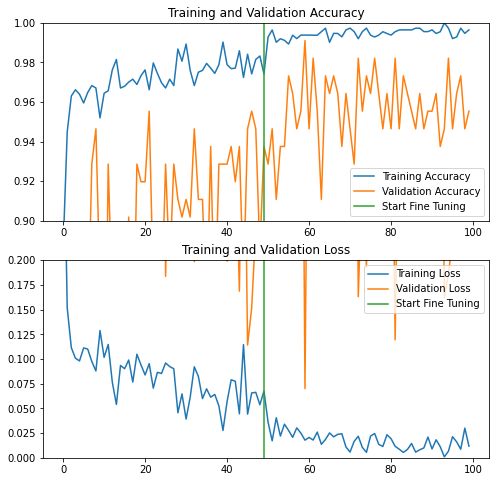

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.9, 1])
plt.plot([epochs-1,epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 0.2])
plt.plot([epochs-1,epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Fine tuning the model

In [36]:
model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(lr=0.0001), 
              metrics=['acc'])

In [37]:
history_fine = model.fit(train_generator, 
                         steps_per_epoch = steps_per_epoch,
                         epochs=50, 
                         workers=4,
                         validation_data=validation_generator, 
                         validation_steps=validation_steps) 

Epoch 1/50
142/142 [==============================] - 30s 208ms/step - loss: 0.0743 - acc: 0.9765 - val_loss: 0.5254 - val_acc: 0.8625
Epoch 2/50
142/142 [==============================] - 29s 205ms/step - loss: 0.0783 - acc: 0.9748 - val_loss: 0.6402 - val_acc: 0.8458
Epoch 3/50
142/142 [==============================] - 29s 206ms/step - loss: 0.0799 - acc: 0.9721 - val_loss: 0.6186 - val_acc: 0.8375
Epoch 4/50
142/142 [==============================] - 29s 207ms/step - loss: 0.0773 - acc: 0.9779 - val_loss: 0.5620 - val_acc: 0.8542
Epoch 5/50
142/142 [==============================] - 30s 210ms/step - loss: 0.0866 - acc: 0.9739 - val_loss: 0.5744 - val_acc: 0.8583
Epoch 6/50
142/142 [==============================] - 30s 208ms/step - loss: 0.0779 - acc: 0.9739 - val_loss: 0.5578 - val_acc: 0.8667
Epoch 7/50
142/142 [==============================] - 29s 204ms/step - loss: 0.0663 - acc: 0.9783 - val_loss: 0.6861 - val_acc: 0.8083
Epoch 8/50
142/142 [==============================] - 2

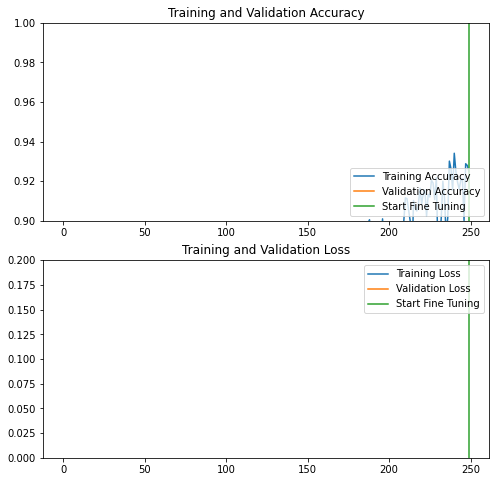

In [38]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.9, 1])
plt.plot([epochs-1,epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 0.2])
plt.plot([epochs-1,epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Official implementation of MobileNetv2 from Keras/applications
Source: https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet/mobilenet.py

In [39]:
from keras import backend as K

In [40]:
def _inverted_res_block(inputs, expansion, stride, alpha, filters, block_id):
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1

    in_channels = K.int_shape(inputs)[channel_axis]
    pointwise_conv_filters = int(filters * alpha)
    pointwise_filters = _make_divisible(pointwise_conv_filters, 8)
    x = inputs
    prefix = 'block_{}_'.format(block_id)

    if block_id:
        # Expand
        x = tf.keras.layers.Conv2D(expansion * in_channels,
                                      kernel_size=1,
                                      padding='same',
                                      use_bias=False,
                                      activation=None,
                                      name=prefix + 'expand')(x)
        x = tf.keras.layers.BatchNormalization(axis=channel_axis,
                                      epsilon=1e-3,
                                      momentum=0.999,
                                      name=prefix + 'expand_BN')(x)
        x = tf.keras.layers.ReLU(6., name=prefix + 'expand_relu')(x)
    else:
        prefix = 'expanded_conv_'

    # Depthwise
    if stride == 2:
        x = tf.keras.layers.ZeroPadding2D(padding=correct_pad(backend, x, 3),
                                                  name=prefix + 'pad')(x)
    x = tf.keras.layers.DepthwiseConv2D(kernel_size=3,
                                                strides=stride,
                                                activation=None,
                                                use_bias=False,
                                                padding='same' if stride == 1 else 'valid',
                                                name=prefix + 'depthwise')(x)
    x = tf.keras.layers.BatchNormalization(axis=channel_axis,
                                                  epsilon=1e-3,
                                                  momentum=0.999,
                                                  name=prefix + 'depthwise_BN')(x)

    x = tf.keras.layers.ReLU(6., name=prefix + 'depthwise_relu')(x)

    # Project
    x = tf.keras.layers.Conv2D(pointwise_filters,
                                      kernel_size=1,
                                      padding='same',
                                      use_bias=False,
                                      activation=None,
                                      name=prefix + 'project')(x)
    x = tf.keras.layers.BatchNormalization(axis=channel_axis,
                                                  epsilon=1e-3,
                                                  momentum=0.999,
                                                  name=prefix + 'project_BN')(x)

    if in_channels == pointwise_filters and stride == 1:
        return tf.keras.layers.Add(name=prefix + 'add')([inputs, x])
    return x

In [41]:
def _make_divisible(v, divisor, min_value=None):
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v

In [42]:
_KERAS_BACKEND = None
_KERAS_LAYERS = None
_KERAS_MODELS = None
_KERAS_UTILS = None

In [46]:
def MobileNetV2(input_shape=None,
                alpha=1.0,
                include_top=True,
                weights='imagenet',
                input_tensor=None,
                pooling=None,
                classes=1000,
                **kwargs):
    """Instantiates the MobileNetV2 architecture.
    # Arguments
        input_shape: optional shape tuple, to be specified if you would
            like to use a model with an input img resolution that is not
            (224, 224, 3).
            It should have exactly 3 inputs channels (224, 224, 3).
            You can also omit this option if you would like
            to infer input_shape from an input_tensor.
            If you choose to include both input_tensor and input_shape then
            input_shape will be used if they match, if the shapes
            do not match then we will throw an error.
            E.g. `(160, 160, 3)` would be one valid value.
        alpha: controls the width of the network. This is known as the
        width multiplier in the MobileNetV2 paper, but the name is kept for
        consistency with MobileNetV1 in Keras.
            - If `alpha` < 1.0, proportionally decreases the number
                of filters in each layer.
            - If `alpha` > 1.0, proportionally increases the number
                of filters in each layer.
            - If `alpha` = 1, default number of filters from the paper
                 are used at each layer.
        include_top: whether to include the fully-connected
            layer at the top of the network.
        weights: one of `None` (random initialization),
              'imagenet' (pre-training on ImageNet),
              or the path to the weights file to be loaded.
        input_tensor: optional Keras tensor (i.e. output of
            `layers.Input()`)
            to use as image input for the model.
        pooling: Optional pooling mode for feature extraction
            when `include_top` is `False`.
            - `None` means that the output of the model
                will be the 4D tensor output of the
                last convolutional block.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional block, and thus
                the output of the model will be a
                2D tensor.
            - `max` means that global max pooling will
                be applied.
        classes: optional number of classes to classify images
            into, only to be specified if `include_top` is True, and
            if no `weights` argument is specified.
    # Returns
        A Keras model instance.
    # Raises
        ValueError: in case of invalid argument for `weights`,
            or invalid input shape or invalid alpha, rows when
            weights='imagenet'
    """
    global backend, layers, models, keras_utils
    backend, layers, models, keras_utils = get_submodules_from_kwargs(kwargs)

    if not (weights in {'imagenet', None} or os.path.exists(weights)):
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization), `imagenet` '
                         '(pre-training on ImageNet), '
                         'or the path to the weights file to be loaded.')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as `"imagenet"` with `include_top` '
                         'as true, `classes` should be 1000')

    # Determine proper input shape and default size.
    # If both input_shape and input_tensor are used, they should match
    if input_shape is not None and input_tensor is not None:
        try:
            is_input_t_tensor = backend.is_keras_tensor(input_tensor)
        except ValueError:
            try:
                is_input_t_tensor = backend.is_keras_tensor(
                    keras_utils.get_source_inputs(input_tensor))
            except ValueError:
                raise ValueError('input_tensor: ', input_tensor,
                                 'is not type input_tensor')
        if is_input_t_tensor:
            if K.image_data_format == 'channels_first':
                if K.int_shape(input_tensor)[1] != input_shape[1]:
                    raise ValueError('input_shape: ', input_shape,
                                     'and input_tensor: ', input_tensor,
                                     'do not meet the same shape requirements')
            else:
                if K.int_shape(input_tensor)[2] != input_shape[1]:
                    raise ValueError('input_shape: ', input_shape,
                                     'and input_tensor: ', input_tensor,
                                     'do not meet the same shape requirements')
        else:
            raise ValueError('input_tensor specified: ', input_tensor,
                             'is not a keras tensor')

    # If input_shape is None, infer shape from input_tensor
    if input_shape is None and input_tensor is not None:

        try:
            K.is_keras_tensor(input_tensor)
        except ValueError:
            raise ValueError('input_tensor: ', input_tensor,
                             'is type: ', type(input_tensor),
                             'which is not a valid type')

        if input_shape is None and not K.is_keras_tensor(input_tensor):
            default_size = 224
        elif input_shape is None and K.is_keras_tensor(input_tensor):
            if K.image_data_format() == 'channels_first':
                rows = K.int_shape(input_tensor)[2]
                cols = K.int_shape(input_tensor)[3]
            else:
                rows = K.int_shape(input_tensor)[1]
                cols = K.int_shape(input_tensor)[2]

            if rows == cols and rows in [96, 128, 160, 192, 224]:
                default_size = rows
            else:
                default_size = 224

    # If input_shape is None and no input_tensor
    elif input_shape is None:
        default_size = 224

    # If input_shape is not None, assume default size
    else:
        if K.image_data_format() == 'channels_first':
            rows = input_shape[1]
            cols = input_shape[2]
        else:
            rows = input_shape[0]
            cols = input_shape[1]

        if rows == cols and rows in [96, 128, 160, 192, 224]:
            default_size = rows
        else:
            default_size = 224

    input_shape = _obtain_input_shape(input_shape,
                                      default_size=default_size,
                                      min_size=32,
                                      data_format=K.image_data_format(),
                                      require_flatten=include_top,
                                      weights=weights)

    if K.image_data_format() == 'channels_last':
        row_axis, col_axis = (0, 1)
    else:
        row_axis, col_axis = (1, 2)
    rows = input_shape[row_axis]
    cols = input_shape[col_axis]

    if weights == 'imagenet':
        if alpha not in [0.35, 0.50, 0.75, 1.0, 1.3, 1.4]:
            raise ValueError('If imagenet weights are being loaded, '
                             'alpha can be one of `0.35`, `0.50`, `0.75`, '
                             '`1.0`, `1.3` or `1.4` only.')

        if rows != cols or rows not in [96, 128, 160, 192, 224]:
            rows = 224
            warnings.warn('`input_shape` is undefined or non-square, '
                          'or `rows` is not in [96, 128, 160, 192, 224].'
                          ' Weights for input shape (224, 224) will be'
                          ' loaded as the default.')

    if input_tensor is None:
        img_input = tf.keras.layers.Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = tf.keras.layers.Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1

    first_block_filters = _make_divisible(32 * alpha, 8)
    x = tf.keras.layers.ZeroPadding2D(padding=correct_pad(backend, img_input, 3),
                             name='Conv1_pad')(img_input)
    x = tf.keras.layers.Conv2D(first_block_filters,
                      kernel_size=3,
                      strides=(2, 2),
                      padding='valid',
                      use_bias=False,
                      name='Conv1')(x)
    x = tf.keras.layers.BatchNormalization(axis=channel_axis,
                                  epsilon=1e-3,
                                  momentum=0.999,
                                  name='bn_Conv1')(x)
    x = tf.keras.layers.ReLU(6., name='Conv1_relu')(x)

    x = _inverted_res_block(x, filters=16, alpha=alpha, stride=1,
                            expansion=1, block_id=0)

    x = _inverted_res_block(x, filters=24, alpha=alpha, stride=2,
                            expansion=6, block_id=1)
    x = _inverted_res_block(x, filters=24, alpha=alpha, stride=1,
                            expansion=6, block_id=2)

    x = _inverted_res_block(x, filters=32, alpha=alpha, stride=2,
                            expansion=6, block_id=3)
    x = _inverted_res_block(x, filters=32, alpha=alpha, stride=1,
                            expansion=6, block_id=4)
    x = _inverted_res_block(x, filters=32, alpha=alpha, stride=1,
                            expansion=6, block_id=5)

    x = _inverted_res_block(x, filters=64, alpha=alpha, stride=2,
                            expansion=6, block_id=6)
    x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1,
                            expansion=6, block_id=7)
    x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1,
                            expansion=6, block_id=8)
    x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1,
                            expansion=6, block_id=9)

    x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1,
                            expansion=6, block_id=10)
    x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1,
                            expansion=6, block_id=11)
    x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1,
                            expansion=6, block_id=12)

    x = _inverted_res_block(x, filters=160, alpha=alpha, stride=2,
                            expansion=6, block_id=13)
    x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1,
                            expansion=6, block_id=14)
    x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1,
                            expansion=6, block_id=15)

    x = _inverted_res_block(x, filters=320, alpha=alpha, stride=1,
                            expansion=6, block_id=16)

    # no alpha applied to last conv as stated in the paper:
    # if the width multiplier is greater than 1 we
    # increase the number of output channels
    if alpha > 1.0:
        last_block_filters = _make_divisible(1280 * alpha, 8)
    else:
        last_block_filters = 1280

    x = tf.keras.layers.Conv2D(last_block_filters,
                      kernel_size=1,
                      use_bias=False,
                      name='Conv_1')(x)
    x = tf.keras.layers.BatchNormalization(axis=channel_axis,
                                  epsilon=1e-3,
                                  momentum=0.999,
                                  name='Conv_1_bn')(x)
    x = tf.keras.layers.ReLU(6., name='out_relu')(x)

    if include_top:
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        x = tf.keras.layers.Dense(classes, activation='softmax',
                         use_bias=True, name='Logits')(x)
    else:
        if pooling == 'avg':
            x = tf.keras.layers.GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = tf.keras.layers.GlobalMaxPooling2D()(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = keras_utils.get_source_inputs(input_tensor)
    else:
        inputs = img_input

    # Create model.
    model = Model(inputs, x,
                         name='mobilenetv2_%0.2f_%s' % (alpha, rows))

    # Load weights.
    if weights == 'imagenet':
        if include_top:
            model_name = ('mobilenet_v2_weights_tf_dim_ordering_tf_kernels_' +
                          str(alpha) + '_' + str(rows) + '.h5')
            weight_path = BASE_WEIGHT_PATH + model_name
            weights_path = keras_utils.get_file(
                model_name, weight_path, cache_subdir='models')
        else:
            model_name = ('mobilenet_v2_weights_tf_dim_ordering_tf_kernels_' +
                          str(alpha) + '_' + str(rows) + '_no_top' + '.h5')
            weight_path = BASE_WEIGHT_PATH + model_name
            weights_path = keras_utils.get_file(
                model_name, weight_path, cache_subdir='models')
        model.load_weights(weights_path)
    elif weights is not None:
        model.load_weights(weights)

    return model


In [47]:
IMG_SHAPE = (224,224,3)
base_mobilenetv2 = MobileNetV2(input_shape=IMG_SHAPE,
                    include_top=False, 
                    weights=None)
base_mobilenetv2.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [51]:
model = tf.keras.Sequential([
  base_mobilenetv2,
  tf.keras.layers.Conv2D(256, 3, activation='relu'),
  tf.keras.layers.Dropout(0.9),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(6, activation='softmax')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 5, 5, 256)         2949376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 256)         0         
_________________________________________________________________
global_average_pooling2d_3 ( (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 1542      
Total params: 5,208,902
Trainable params: 5,174,790
Non-trainable params: 34,112
_________________________________________________________________


In [52]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),   
              loss='categorical_crossentropy', 
              metrics=['acc'])

In [53]:
batch_size = 16
epochs = 200
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size

history = model.fit(train_generator, 
                              steps_per_epoch = steps_per_epoch,
                              epochs=epochs, 
                              workers=1,
                              validation_data=validation_generator, 
                              validation_steps=validation_steps)

Epoch 1/200
142/142 [==============================] - 37s 259ms/step - loss: 1.9103 - acc: 0.3292 - val_loss: 1.7689 - val_acc: 0.1625
Epoch 2/200
142/142 [==============================] - 36s 255ms/step - loss: 1.5250 - acc: 0.4199 - val_loss: 1.7538 - val_acc: 0.1958
Epoch 3/200
142/142 [==============================] - 36s 255ms/step - loss: 1.4681 - acc: 0.4540 - val_loss: 1.8300 - val_acc: 0.1708
Epoch 4/200
142/142 [==============================] - 36s 255ms/step - loss: 1.4218 - acc: 0.4597 - val_loss: 1.8237 - val_acc: 0.1917
Epoch 5/200
142/142 [==============================] - 36s 256ms/step - loss: 1.3958 - acc: 0.4916 - val_loss: 1.8065 - val_acc: 0.1958
Epoch 6/200
142/142 [==============================] - 37s 263ms/step - loss: 1.4146 - acc: 0.4832 - val_loss: 1.8906 - val_acc: 0.2042
Epoch 7/200
142/142 [==============================] - 37s 259ms/step - loss: 1.3571 - acc: 0.4903 - val_loss: 2.0327 - val_acc: 0.2042
Epoch 8/200
142/142 [===========================

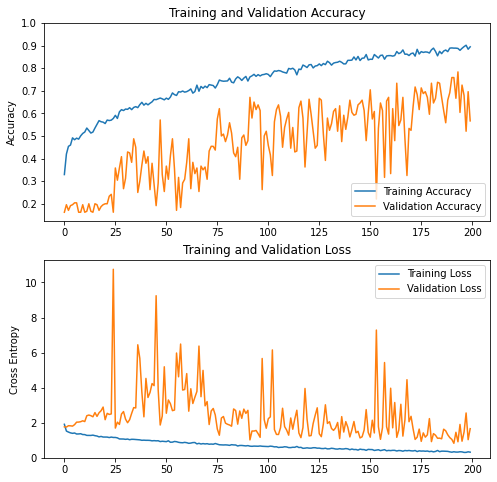

In [54]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

(1, 6)
cardboard


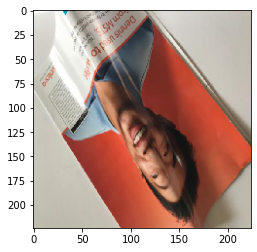

In [55]:
img_path = '/content/drive/My Drive/Garbage classification/paper/paper9.jpg'

img=np.array(img)/255.0
img = image.load_img(img_path, target_size=(224, 224))
img = image.img_to_array(img, dtype=np.uint8)
plt.imshow(img.squeeze())
p=model.predict(img[np.newaxis, ...])
print(p.shape)
predicted_class = label[np.argmax(p[0][0], axis=-1)]
print(predicted_class)

Fine tuning MobileNetv2

In [2]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),   
              loss='categorical_crossentropy', 
              metrics=['acc'])

NameError: ignored

In [1]:
history = model.fit(train_generator, 
                              steps_per_epoch = steps_per_epoch,
                              epochs=100, 
                              workers=1,
                              validation_data=validation_generator, 
                              validation_steps=validation_steps)

NameError: ignored